In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [ ]:
!pip install timm

In [ ]:
from timm import create_model
from functools import reduce
from operator import mul
import math
import torch
import torch.nn as nn
import os
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
from torchsummary import summary
import numpy as np
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import random

def torch_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
    # CUDA randomness
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    np.random.seed(random_seed)
    random.seed(random_seed)
    os.environ['PYTHONHASHSEED'] = str(random_seed)

torch_seed(2024)

In [ ]:
device

device(type='cuda')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm
from torchsummary import summary

In [ ]:
# TrainVal Dataset
from torchvision.datasets import VOCSegmentation

trainval_data = VOCSegmentation(root='/content/VOC', year='2012', image_set='trainval', download=True)

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Paths to the images
image_path1 = '/content/VOC/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg'
image_path2 = '/content/VOC/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png'
# Load the images
image1 = Image.open(image_path1)
image2 = Image.open(image_path2)
# Create a figure with two subplots
plt.figure(figsize=(12, 6))  # Adjust the size as needed

# Display the first image
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.imshow(image1)
plt.axis('off')  # Turn off axis numbers
plt.title('Original Image')

# Display the second image
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.imshow(image2)
plt.axis('off')  # Turn off axis numbers
plt.title('Segmentation Class')

# Show the plot
plt.show()


In [ ]:
import shutil

file_list = []
filelist_path = '/content/VOC/VOCdevkit/VOC2012/ImageSets/Segmentation/trainval.txt'
f = open(filelist_path,'r')
line = None
while True :
  line = f.readline().replace('\n','')
  if line is None or len(line) == 0 :
    break
  file_list.append(line)

f.close()

In [ ]:
file_list

In [ ]:
os.makedirs('/content/VOC/VOCdevkit/VOC2012/SegImgs')

In [ ]:
root = '/content/VOC/VOCdevkit/VOC2012/'
to_path = root + 'SegImgs'

for filename in file_list:
    from_path = os.path.join(root, 'JPEGImages', filename + '.jpg')
    if os.path.exists(from_path):
        shutil.copy2(from_path, to_path)
        print(f"Copied: {from_path} to {to_path}")
    else:
        print(f"File not found: {from_path}")


In [ ]:
IMAGE_PATH = '/content/VOC/VOCdevkit/VOC2012/SegImgs/'
MASK_PATH = '/content/VOC/VOCdevkit/VOC2012/SegmentationClass/'

In [ ]:
import numpy as np

def make_colormap(num=256):
   def bit_get(val, idx):
       return (val >> idx) & 1

   colormap = np.zeros((num, 3), dtype=int)
   ind = np.arange(num, dtype=int)

   for shift in reversed(list(range(8))):
       for channel in range(3):
           colormap[:, channel] |= bit_get(ind, channel) << shift
       ind >>= 3

   return colormap

cmap = make_colormap(256).tolist()
palette = [value for color in cmap for value in color]
print(cmap, "\n", palette)


In [ ]:
# 원본 이미지와 저장할 폴더 경로 설정
root = '/content/VOC/VOCdevkit/VOC2012/'
from_path = os.path.join(root, 'SegmentationClass')
to_path = os.path.join(root, 'SegGT')

# 저장할 폴더 생성 (이미 존재하는 경우 생성하지 않음)
if not os.path.exists(to_path):
    os.makedirs(to_path)

# 원본 폴더 내의 모든 파일에 대해 반복
for filename in os.listdir(from_path):
    if filename.endswith('.png'):
        file_path = os.path.join(from_path, filename)

        # 이미지 불러오기
        label_img = cv2.imread(file_path, cv2.IMREAD_COLOR)
        label_img = cv2.cvtColor(label_img, cv2.COLOR_BGR2RGB)

        # 변환된 이미지를 저장할 ndarray 생성
        img_png = np.zeros((label_img.shape[0], label_img.shape[1]), np.uint8)

        # 색상 맵을 사용하여 픽셀값 변환
        for index, val_col in enumerate(cmap):
            img_png[np.where(np.all(label_img == val_col, axis=-1))] = index

        # 변환된 ndarray를 PIL Image 객체로 변환 및 팔레트 적용
        img_png = Image.fromarray(img_png).convert('P')
        img_png.putpalette(palette)

        # 변환된 이미지 저장
        save_path = os.path.join(to_path, filename)
        img_png.save(save_path)
        print(f"Saved: {save_path}")

In [ ]:
from google.colab import files

files.download('/content/VOC')


In [ ]:
!zip -r my_files.zip /content/VOC/VOCdevkit/VOC2012/SegGT
!zip -r my_files.zip /content/VOC/VOCdevkit/VOC2012/SegImgs
!gdrive upload my_files.zip


#드라이브에 이미지 있으면 여기서부터


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
IMAGE_PATH = '/voc/content/VOC/VOCdevkit/VOC2012/SegImgs/'
GT_PATH ='/voc/content/VOC/VOCdevkit/VOC2012/SegGT/'

In [ ]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/my_files.zip', 'r') as zip_ref:
  zip_ref.extractall('/voc')

In [ ]:
def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])

    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  2913


In [ ]:
#split data
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  2227
Val Size     :  394
Test Size    :  292


Image Size (375, 500, 3)
Mask Size (375, 500)


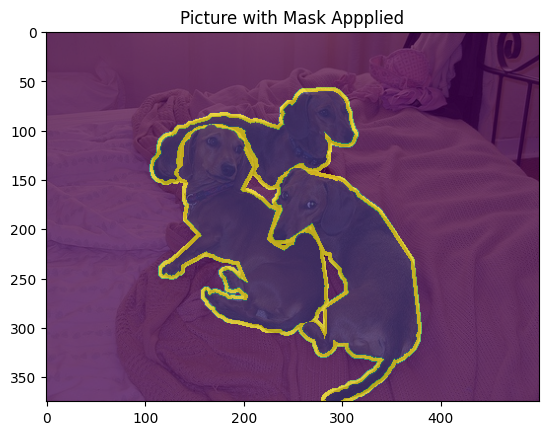

In [ ]:
img = Image.open(IMAGE_PATH + df['id'][2] + '.jpg').convert('RGB')
mask = cv2.imread(GT_PATH + df['id'][2]  + '.png', cv2.IMREAD_GRAYSCALE)
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.7)
plt.title('Picture with Mask Appplied')
plt.show()

In [ ]:
mask[150]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0, 220, 220, 220, 220, 220, 220, 220, 220,
       220, 220,  33,  33,  33,  33,  33,  33, 220, 220, 220, 220, 220,
       220,  33, 220, 220, 220, 220, 220, 220, 220, 220, 220,  33,  33,
        33,  33,  33,  33,  33,  33,  33,  33,  33,  33,  33,  33,  33,
        33,  33,  33,  33,  33,  33,  33,  33,  33,  33,  33,  33,  33,
        33,  33,  33,  33,  33,  33,  33,  33,  33,  33,  33,  3

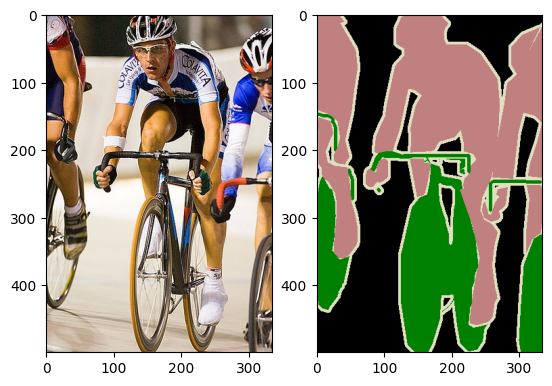

In [ ]:
file_name = '2007_000129'

img = Image.open(IMAGE_PATH + file_name + '.jpg')
mask = Image.open(GT_PATH + file_name + '.png')
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(mask)

In [ ]:
torch.tensor(np.array(mask)[200])

tensor([255, 255,  15,  15,  15,  15,  15,  15,  15,  15,  15,  15,  15,  15,
        255, 255, 255, 255, 255,   0,   0, 255, 255, 255, 255,   2,   2,   2,
          2,  15,  15,  15,  15,  15,  15,  15,  15,  15,  15,  15,  15,  15,
         15,  15,  15, 255, 255, 255, 255, 255,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 255, 255, 255,
        255,  15,  15,  15,  15,  15,  15,  15,  15,  15,  15,  15,  15,  15,
         15,  15,  15,  15,  15,  15,  15,  15,  15,  15,  15,  15,  15,  15,
         15, 255, 255, 255, 255, 255,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0, 255, 255, 255, 255,  15,  15,
         15,  15,  15,  15,  15,  15,  15,  15,  15,  15,  15,  15,  15,  15,
         15,  15,  15,  15,  15,  15,  15,  15,  15,  15,  15,  15,  15,  15,
         15,  15,  15,  15,  15,  15, 255, 255, 255, 255, 255,  

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

class VOCDataset(Dataset):

    def __init__(self, img_path, mask_path, X, mean, std, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = np.array(Image.open(self.mask_path + self.X[idx] + '.png'))

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        mask = torch.where(mask == 255, torch.tensor(0), mask).long()


        return img, mask



In [ ]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]


t_train = A.Compose([
    A.Resize(224, 224, interpolation=cv2.INTER_NEAREST,always_apply = True),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
    A.RandomRotate90(),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5)
])

t_val = A.Compose([
    A.Resize(224, 224, interpolation=cv2.INTER_NEAREST,always_apply = True),
    A.HorizontalFlip(),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1)
])


#datasets
train_set = VOCDataset(IMAGE_PATH, GT_PATH, X_train, mean, std,t_train)
val_set = VOCDataset(IMAGE_PATH, GT_PATH, X_val, mean, std,t_val)

#dataloader
batch_size= 16

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [ ]:
aa = t_train(image = np.array(img), mask = np.array(mask))

sm = aa['mask']

sm

array([[ 0,  0,  0, ..., 15, 15, 15],
       [ 0,  0,  0, ..., 15, 15, 15],
       [ 0,  0,  0, ..., 15, 15, 15],
       ...,
       [ 2,  2,  2, ...,  0,  0,  0],
       [ 2,  2,  2, ...,  0,  0,  0],
       [ 2,  2,  2, ...,  0,  0,  0]], dtype=uint8)

In [ ]:
val_set[1][0]

tensor([[[-0.0801, -0.0801, -0.1143,  ...,  0.0398,  0.0398, -0.0116],
         [-0.0287, -0.0116, -0.0458,  ...,  0.0056,  0.0227, -0.0116],
         [ 0.1083,  0.0569,  0.0227,  ...,  0.0569,  0.1083,  0.0741],
         ...,
         [-1.1075, -0.9020, -1.3302,  ..., -1.5699, -1.4500, -1.5185],
         [-1.2274, -1.5014, -1.3644,  ..., -1.6384, -1.7412, -1.6384],
         [-2.0152, -1.8610, -1.9124,  ..., -1.8610, -1.7069, -1.8268]],

        [[ 0.9405,  0.9230,  0.9055,  ...,  1.0105,  1.0105,  1.0280],
         [ 1.0105,  0.9930,  0.9755,  ...,  1.0455,  1.0455,  1.0280],
         [ 1.0630,  1.0280,  1.0280,  ...,  1.0280,  1.0630,  1.0455],
         ...,
         [-0.6702, -0.5301, -0.9853,  ..., -1.2654, -1.2129, -1.4405],
         [-0.9153, -1.3004, -1.1253,  ..., -1.3880, -1.5105, -1.3354],
         [-1.7031, -1.7206, -1.7906,  ..., -1.5105, -1.4230, -1.5630]],

        [[ 2.1171,  2.0648,  2.0474,  ...,  2.0823,  2.0300,  2.0648],
         [ 2.0474,  2.0997,  2.1171,  ...,  2

In [ ]:
train_set[10][1][150]

tensor([ 0, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15,  0,  0,  0,  0,  0,  0,  0, 15, 15, 15,  0,  0,  0,  0,  0,  0, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15,  0,  0,  0,  0, 18, 18, 18, 18,
        18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
        18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
        18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
         0,  0,  0,  0, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15,  0])

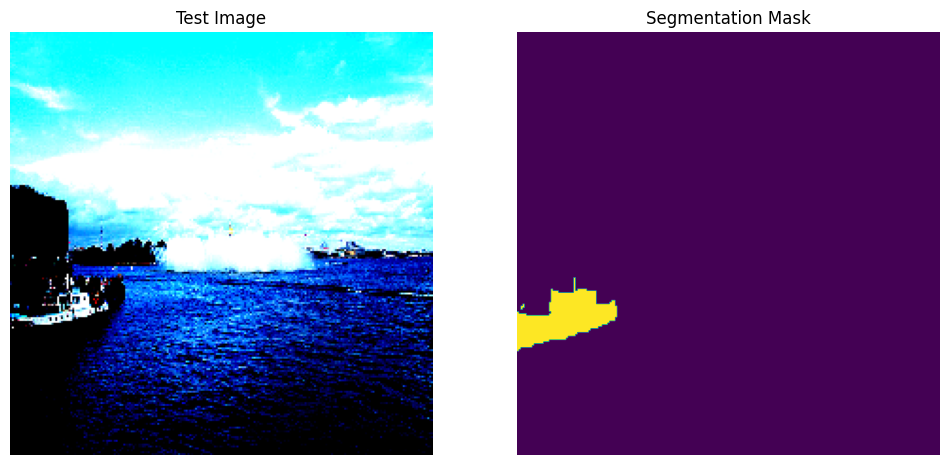

In [ ]:
import matplotlib.pyplot as plt

# 데이터셋에서 테스트 이미지와 마스크 로드
test_img, test_mask = val_set[1]  # 예를 들어 첫 번째 테스트 이미지와 마스크를 선택

# 이미지와 마스크를 NumPy 배열로 변환
test_img_np = test_img.permute(1, 2, 0).numpy()  # PyTorch 텐서를 NumPy 배열로 변환
test_mask_np = test_mask.numpy()

# 이미지 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(test_img_np)
plt.title("Test Image")
plt.axis('off')

# 마스크 시각화
plt.subplot(1, 2, 2)
plt.imshow(test_mask_np)
plt.title("Segmentation Mask")
plt.axis('off')

plt.show()


In [ ]:
a = [np.unique(val_set[i][1]) for i in range(len(val_set))]
combined_list = [item for sublist in a for item in sublist]
np.unique(combined_list)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

In [ ]:
print(len(list(set(combined_list))))

21


In [ ]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size,
                                   padding=padding, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=3 , padding = 1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

아래 코드는 CLS 토큰 혹은 prompt를 이용하지 않고 있다.

토큰 재배열: 트랜스포머 모델의 출력을 재배열하여 일정한 차원의 그리드에 맞도록 조정할 수 있습니다. 이 경우, 일부 토큰은 특정 그리드 셀에 직접 대응되지 않을 수 있습니다.

출력 차원 조정: 출력 토큰의 수를 변경하여 정사각형 형태의 이미지 그리드로 변환할 수 있는 수로 조정할 수 있습니다. 이를 위해 추가적인 토큰을 추가하거나 제거할 수 있습니다.

In [ ]:
class SegmentationHead(nn.Module):
    def __init__(self, num_classes: int, hidden_dim: int = 768):
        super(SegmentationHead, self).__init__()
        # 업샘플링과 깊이별 분리 컨볼루션 레이어
        # self.upsample = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)
        self.upsample2 = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)
        self.conv1 = DepthwiseSeparableConv(hidden_dim, hidden_dim//8, kernel_size=3, padding=1)
        # self.conv2 = DepthwiseSeparableConv(hidden_dim // 4, hidden_dim // 16, kernel_size=3, padding=1)
        # self.conv2_2 = DepthwiseSeparableConv(hidden_dim // 4, hidden_dim // 4, kernel_size=3, padding=1)
        # self.conv3 = DepthwiseSeparableConv(hidden_dim // 4, hidden_dim // 8, kernel_size=3, padding=1)
        # self.conv3_3 = DepthwiseSeparableConv(hidden_dim // 8, hidden_dim // 8, kernel_size=3, padding=1)
        # self.conv4 = DepthwiseSeparableConv(hidden_dim // 8, hidden_dim // 16, kernel_size=3, padding=1)
        self.final_conv = nn.Conv2d(hidden_dim // 8, num_classes, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(hidden_dim // 8)
        # self.bn2 = nn.BatchNorm2d(hidden_dim // 16)
        # self.bn3 = nn.BatchNorm2d(hidden_dim // 8)
        # self.bn4 = nn.BatchNorm2d(hidden_dim // 16)
    def forward(self, x):

        # 첫 번째 컨볼루션 및 배치 정규화
        x = self.conv1(x)
        # x = self.conv1_1(x)
        x = self.bn1(x)
        x = F.gelu(x)
        x = self.upsample2(x)

        # 두 번째 컨볼루션 및 배치 정규화
        # x = self.conv2(x)
        # # x = self.conv2_2(x)
        # x = self.bn2(x)
        # x = F.gelu(x)
        # x = self.upsample(x)

        # # 세 번째 컨볼루션 및 배치 정규화
        # x = self.conv3(x)
        # x = self.conv3_3(x)
        # x = self.bn3(x)
        # x = F.prelu(x)
        # x = self.upsample(x)

        # # 네 번째 컨볼루션 및 배치 정규화
        # x = self.conv4(x)
        # x = self.bn4(x)
        # x = F.prelu(x)
        # x = self.upsample(x)
        # x= self.upsample2(x)
        # 최종 컨볼루션
        x = self.final_conv(x)
        return x


class VPT(nn.Module):
    def __init__(self, modelname: str, num_classes: int, pretrained: bool = True,
                 prompt_tokens: int = 5, prompt_dropout: float = 0.0, prompt_type: str = 'shallow'):
        super().__init__()
        self.encoder = create_model(modelname, pretrained=pretrained)
        hidden_dim = self.encoder.embed_dim
        del self.encoder.head
        self.encoder.head = SegmentationHead(num_classes=num_classes)

        for n, p in self.encoder.named_parameters():
            if 'head' not in n:
                p.requires_grad = False

        self.prompt_tokens = prompt_tokens
        self.prompt_dropout = nn.Dropout(prompt_dropout)
        self.prompt_dim = self.encoder.embed_dim
        self.prompt_type = prompt_type
        assert self.prompt_type in ['shallow', 'deep'], "prompt type should be 'shallow' or 'deep'."

        self.prompt_embeddings = nn.Parameter(torch.zeros(1, self.prompt_tokens, self.prompt_dim))
        nn.init.uniform_(self.prompt_embeddings, -1, 1)

        if self.prompt_type == 'deep':
            self.total_d_layer = len(self.encoder.blocks)
            self.deep_prompt_embeddings = nn.Parameter(
                torch.zeros(self.total_d_layer-1, self.prompt_tokens, self.prompt_dim)
            )
            nn.init.uniform_(self.deep_prompt_embeddings, -1, 1)

    def train(self, mode=True):
        super().train(mode=False)
        self.prompt_dropout.train(mode)
        self.encoder.head.train(mode)

    def incorporate_prompt(self, x, prompt_embeddings, n_prompt: int = 0): #prepend
        B = x.shape[0]
        x = torch.cat((
            x[:, :1, :],
            self.prompt_dropout(prompt_embeddings.expand(B, -1, -1)),
            x[:, (1+n_prompt):, :]
        ), dim=1)
        return x

    # def incorporate_prompt(self, x, prompt_embeddings):
    #     B, N, C = x.shape  # x의 차원을 올바르게 언패킹합니다.
    #     prompt = self.prompt_dropout(prompt_embeddings.expand(B, -1, -1))

    #     # x와 prompt를 시퀀스 차원을 기준으로 연결
    #     x = torch.cat((x, prompt), dim=1)
    #     return x

    def forward_features(self, x):
        x = self.encoder.patch_embed(x)
        cls_tokens = self.encoder.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.encoder.pos_embed
        x = self.encoder.pos_drop(x)

        x = self.incorporate_prompt(x, self.prompt_embeddings)

        if self.prompt_type == 'deep':
            for i, blk in enumerate(self.encoder.blocks):
                if i > 0:
                    x = self.incorporate_prompt(x, self.deep_prompt_embeddings[i-1], self.prompt_tokens)
                x = blk(x)
        else:
            x = self.encoder.blocks(x)

        x = self.encoder.norm(x)
        B, N, C = x.shape
        # CLS 토큰과 prompt 토큰을 제외한 실제 패치의 수 계산
        N = N - 1-self.prompt_tokens  # CLS 토큰과 prompt 토큰 수를 빼줌
        H = W = int(math.sqrt(N))
        # 채널 차원과 공간 차원을 올바르게 배치
        x = x[:, 1+self.prompt_tokens:, :].permute(0, 2, 1).contiguous().view(B, C, H, W)
        return x

    def forward(self, x):
      x = self.forward_features(x)

      x = self.encoder.head(x)

      return x



In [ ]:
sample_vit = create_model( 'vit_base_patch16_224')
sample_vit

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [ ]:
model = VPT(modelname = 'vit_base_patch8_224',num_classes = 21,prompt_type='shallow',prompt_tokens=5)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

prompt_embeddings
encoder.head.conv1.depthwise.weight
encoder.head.conv1.depthwise.bias
encoder.head.conv1.pointwise.weight
encoder.head.conv1.pointwise.bias
encoder.head.final_conv.weight
encoder.head.final_conv.bias
encoder.head.bn1.weight
encoder.head.bn1.bias


In [ ]:
model.to(device)
x = (torch.rand(32,3,224,224).to(device))
y = model.encoder.patch_embed(x)
print(y.shape)
print(model.prompt_embeddings.shape)
print(model.incorporate_prompt(y, model.prompt_embeddings).shape)

torch.Size([32, 784, 768])
torch.Size([1, 5, 768])
torch.Size([32, 789, 768])


In [ ]:
max_lr = 1e-3
epoch = 1
weight_decay = 1e-4

criterion =  nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

data = next(iter(train_loader))
image_tiles, mask_tiles = data
print(image_tiles.shape)
print(mask_tiles.shape)
image = image_tiles.to(device)
mask = mask_tiles.to(device)
model.to(device)
#forward
o = model.forward_features(image)
print(o.shape)
output = model(image)
print(output.shape)
print(mask.shape)
mask = mask.long()
loss = criterion(output, mask)
print(loss)

In [ ]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [ ]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=21):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, model_name , patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)

            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight
            optimizer.zero_grad() #reset gradient

            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)

                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)
                    test_loss += loss.item()

            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, '/content/drive/MyDrive/VPTSegModels/{}_SegVPT_mIoU-{:.3f}.pt'.format(model_name, val_iou_score/len(val_loader)))


            if (test_loss/len(val_loader)) > min_loss:
                not_improve   += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                # if not_improve == 20:
                #     print('Loss not decrease for 20 times, Stop Training')
                #     break

            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))

    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [ ]:
max_lr = 5e-2
epoch = 100
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = CosineAnnealingWarmUpRestarts(optimizer,T_0=10, T_mult=2, eta_max = max_lr,  T_up=1, gamma=0.5)


history_8 = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched,'5_prepend with 8 patch')

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.548 
Epoch:1/100.. Train Loss: 0.956.. Val Loss: 0.548.. Train mIoU:0.163.. Val mIoU: 0.339.. Train Acc:0.767.. Val Acc:0.827.. Time: 5.45m


  0%|          | 0/140 [00:00<?, ?it/s]

In [ ]:
plot_metrics(history_8)

NameError: name 'history' is not defined

In [ ]:
image, mask = test_set[100]
pred_mask, score = predict_image_mask_miou(model, image, mask)
print(score)

0.49654217155626656


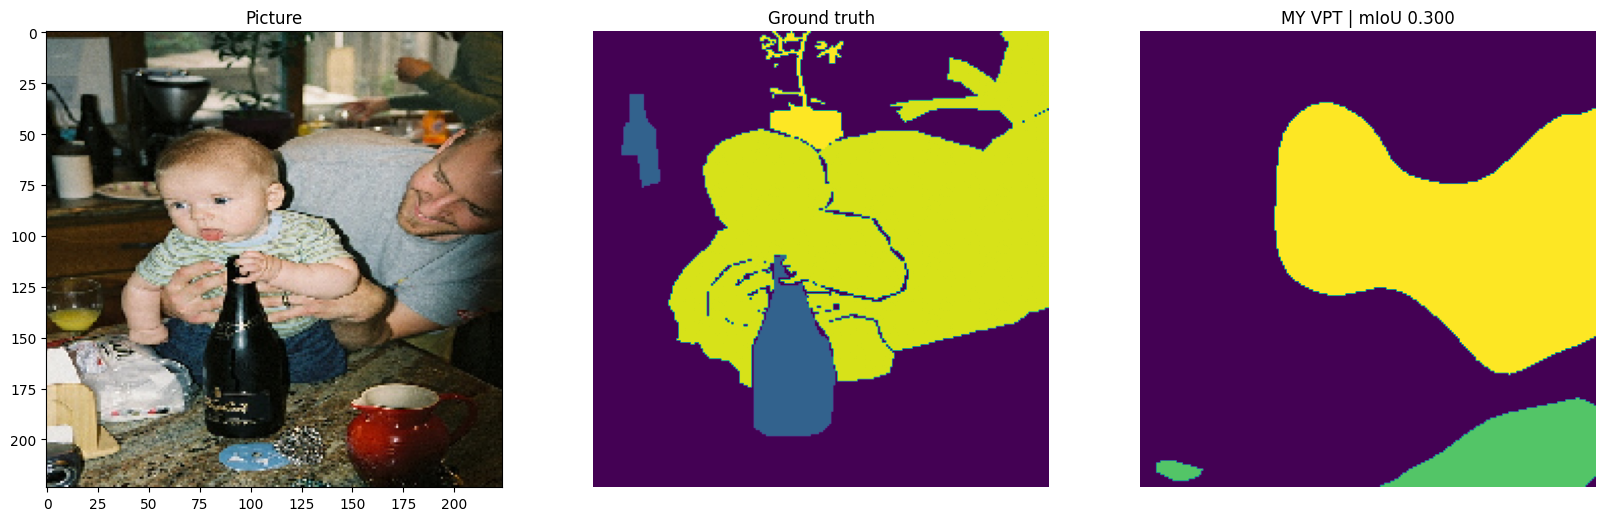

In [ ]:
image2, mask2 = test_set[19]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('MY VPT | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

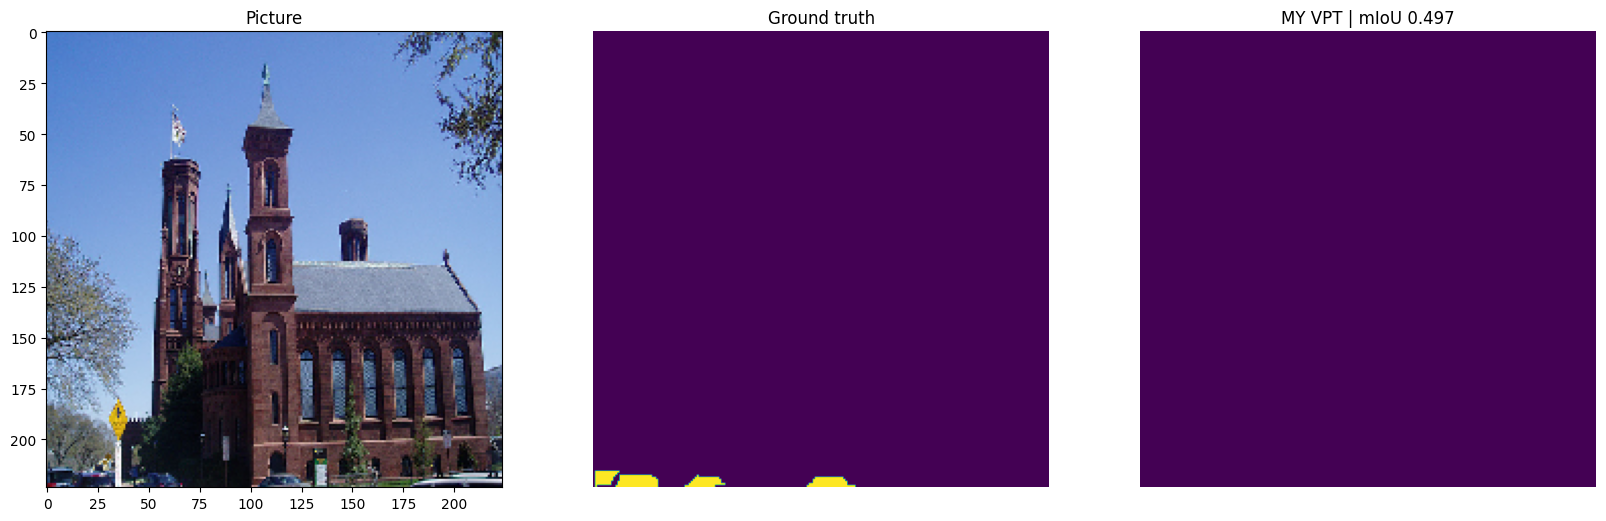

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('MY VPT | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

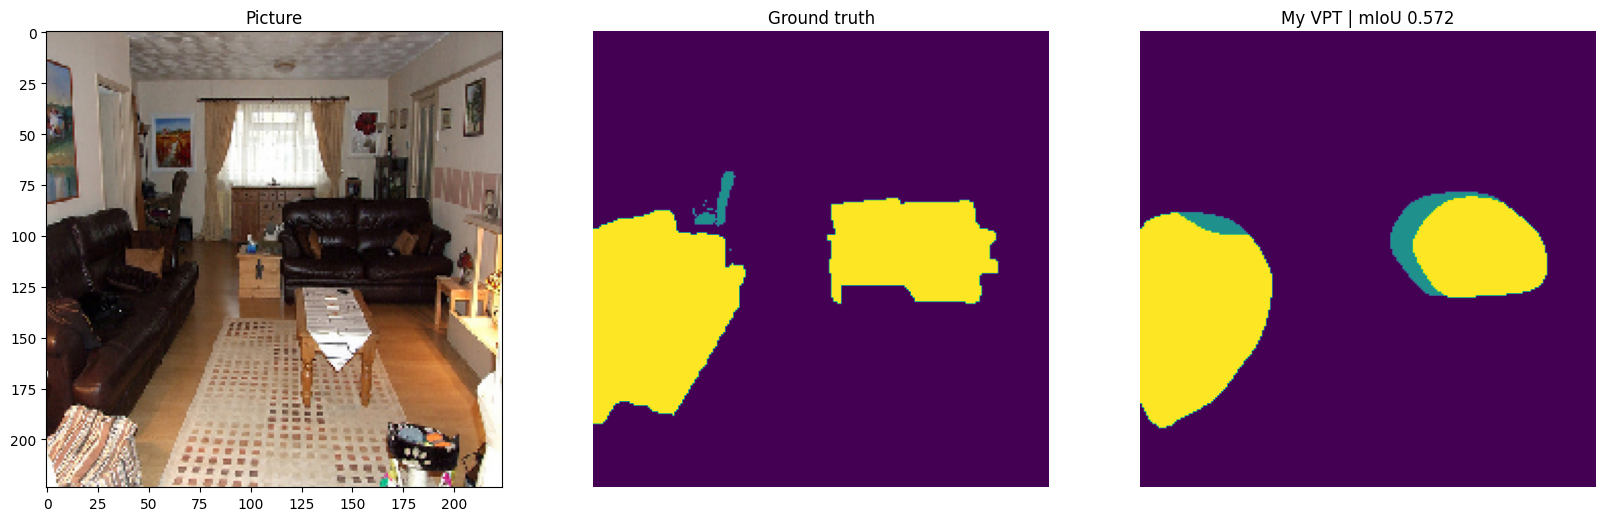

In [ ]:
image3, mask3 = test_set[14]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('My VPT | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()

In [ ]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [ ]:
class TestDataset(Dataset):

    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = np.array(Image.open(self.mask_path + self.X[idx] + '.png'))

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        mask = torch.from_numpy(mask).long()

        mask = torch.where(mask == 255, torch.tensor(0), mask).long()
        return img, mask


In [ ]:
t_test = A.Resize(224, 224, interpolation=cv2.INTER_NEAREST)
test_set = TestDataset(IMAGE_PATH, GT_PATH, X_test, transform=t_test)

In [ ]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc


In [ ]:
image, mask = test_set[100]
pred_mask, score = predict_image_mask_miou(model, image, mask)
print(score)

0.49654217155626656


In [ ]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [ ]:
mob_miou = miou_score(model, test_set)

  0%|          | 0/292 [00:00<?, ?it/s]

In [ ]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [ ]:
mob_acc = pixel_acc(model, test_set)

  0%|          | 0/292 [00:00<?, ?it/s]

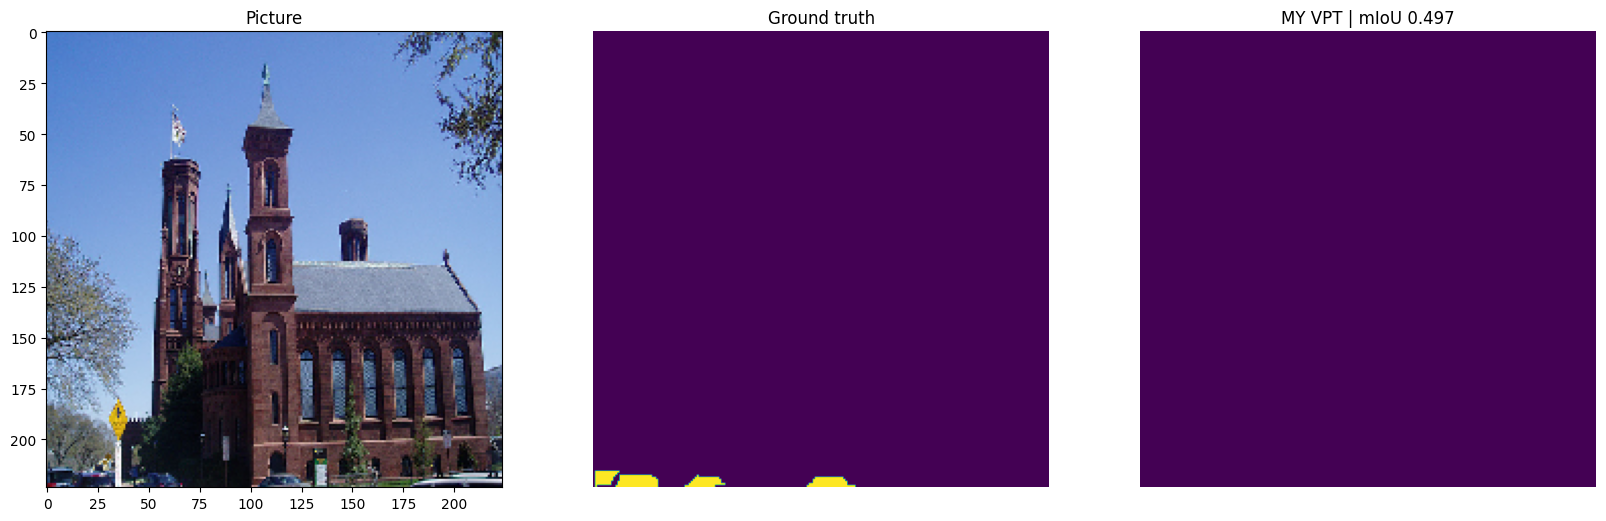

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('MY VPT | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

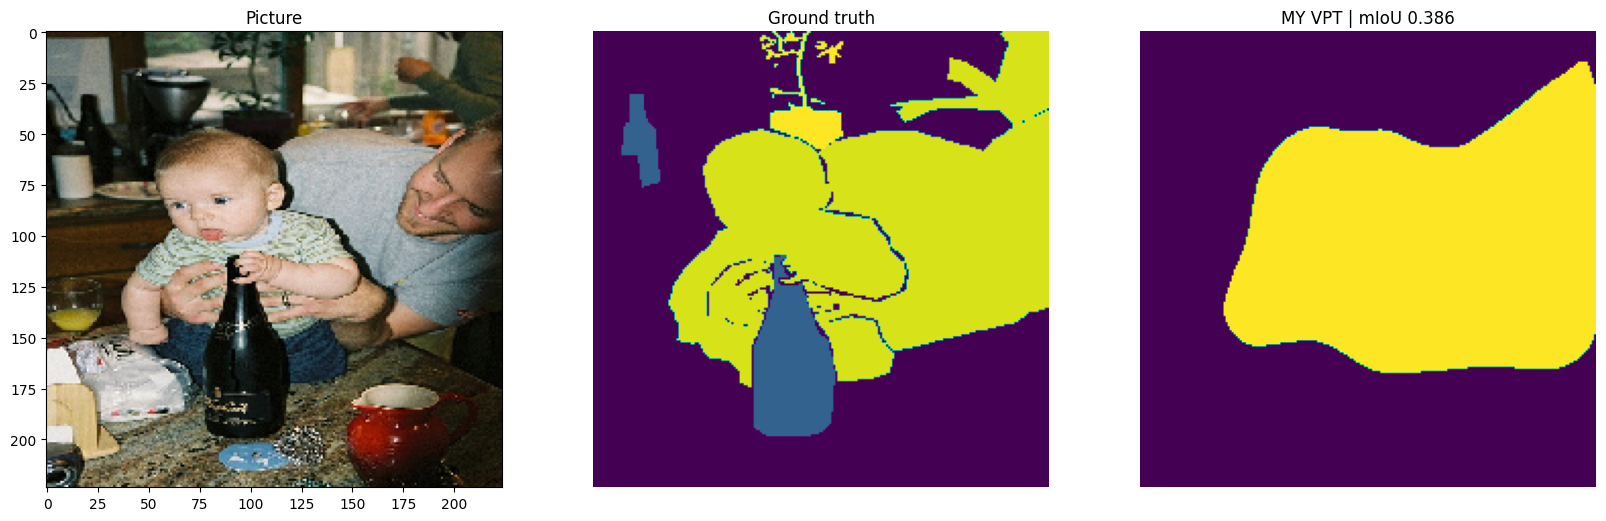

In [ ]:
image2, mask2 = test_set[19]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('MY VPT | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

In [ ]:
pred_mask2[100]

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15])

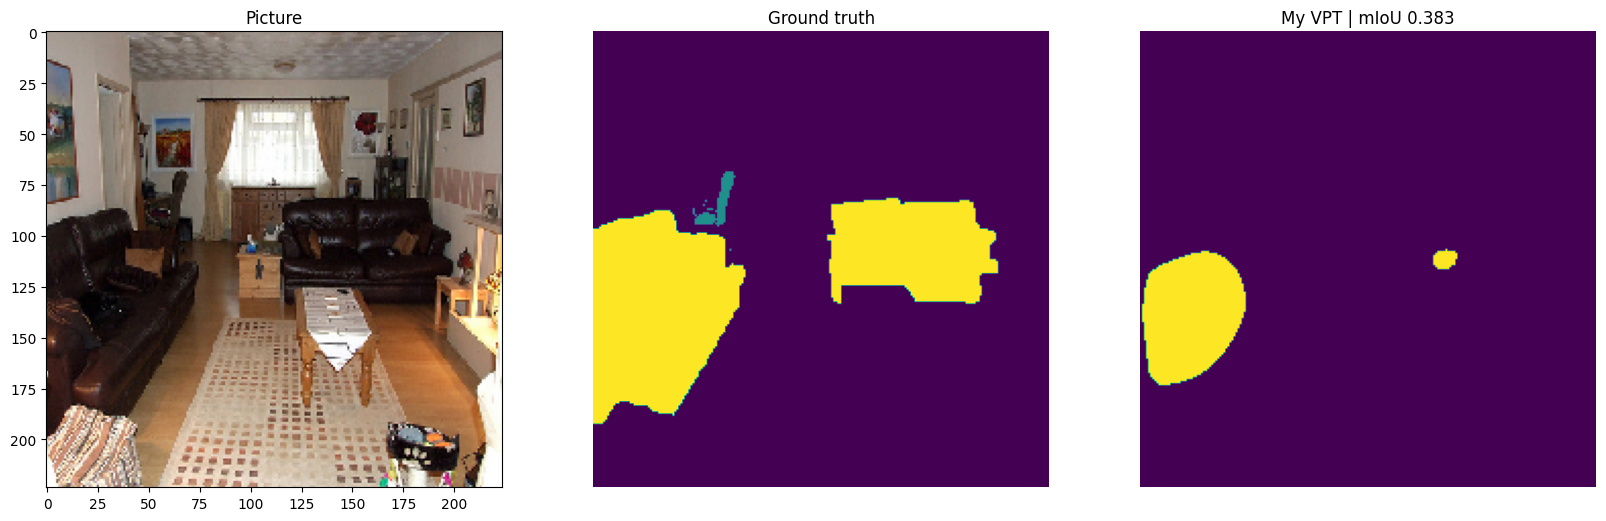

In [ ]:
image3, mask3 = test_set[14]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('My VPT | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()

In [ ]:
a = [np.unique(pred_mask3)]
a

[array([ 0, 18])]

In [ ]:
print('Test Set mIoU', np.nanmean(mob_miou))

Test Set mIoU 0.5927784346669568


In [ ]:
print('Test Set Pixel Accuracy', np.mean(mob_acc))

Test Set Pixel Accuracy 0.8804613923373288


In [ ]:
model2 = VPT(modelname = 'vit_base_patch16_224',num_classes = 21,prompt_type='shallow',pretrained = True , prompt_tokens= 5,prompt_dropout = 0.0)


In [ ]:
model2 = torch.load('/content/drive/MyDrive/VPTSegModels/SegVPT_mIoU-0.589.pt')

In [ ]:
for name, param in model2.named_parameters():
    if param.requires_grad:
        print(name)

prompt_embeddings
encoder.head.conv1.depthwise.weight
encoder.head.conv1.depthwise.bias
encoder.head.conv1.pointwise.weight
encoder.head.conv1.pointwise.bias
encoder.head.final_conv.weight
encoder.head.final_conv.bias
encoder.head.bn1.weight
encoder.head.bn1.bias


In [ ]:
import torch
from torch.optim.lr_scheduler import _LRScheduler

class WarmupCosineAnnealingLR(_LRScheduler):
    def __init__(self, optimizer, warmup_epochs, total_epochs, warmup_start_lr, max_lr, last_epoch=-1):
        self.warmup_epochs = warmup_epochs
        self.total_epochs = total_epochs
        self.warmup_start_lr = warmup_start_lr
        self.max_lr = max_lr
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch < self.warmup_epochs:
            # Warm-up phase
            lr = ((self.max_lr - self.warmup_start_lr) / self.warmup_epochs) * self.last_epoch + self.warmup_start_lr
        else:
            # Cosine Annealing phase
            lr = self.max_lr * 0.5 * (1 + torch.cos(torch.pi * (self.last_epoch - self.warmup_epochs) / (self.total_epochs - self.warmup_epochs)))
        return [lr for _ in self.optimizer.param_groups]

In [ ]:
max_lr = 1e-1
epoch = 1
weight_decay = 1e-4

criterion =  nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model2.parameters(), lr=max_lr, weight_decay=weight_decay)
sched =  WarmupCosineAnnealingLR(optimizer, warmup_epochs=5, total_epochs=epoch, warmup_start_lr=0.0001, max_lr=max_lr)

data = next(iter(train_loader))
image_tiles, mask_tiles = data
print(image_tiles.shape)
print(mask_tiles.shape)
image = image_tiles.to(device)
mask = mask_tiles.to(device)
model2.to(device)
#forward
o = model2.forward_features(image)
print(o.shape)
output = model2(image)
print(output.shape)
print(mask.shape)
mask = mask.long()
loss = criterion(output, mask)
print(loss)

torch.Size([32, 3, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 768, 14, 14])
torch.Size([32, 21, 224, 224])
torch.Size([32, 224, 224])
tensor(2.9812, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


In [ ]:
class MulticlassDiceLoss(nn.Module):
    def __init__(self, num_classes, smooth=1.):
        super(MulticlassDiceLoss, self).__init__()
        self.num_classes = num_classes
        self.smooth = smooth

    def forward(self, inputs, targets):
        dice_loss = 0.0
        for i in range(self.num_classes):
            dice_loss += self.dice_loss(inputs[:, i], targets == i)
        return dice_loss / self.num_classes

    def dice_loss(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)

        return 1 - dice



Cross Entropy for Segmentation

In [ ]:
import math
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch

        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

Warm UP Cosine Annealing Scheduler

https://gaussian37.github.io/dl-pytorch-lr_scheduler/

In [ ]:
max_lr = 5e-2
epoch = 150
weight_decay = 0.0

criterion =  nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model2.parameters(), lr = max_lr, weight_decay=weight_decay)
# sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
#                                             steps_per_epoch=len(train_loader))
sched = CosineAnnealingWarmUpRestarts(optimizer,T_0=10, T_mult=2, eta_max = max_lr,  T_up=1, gamma=0.5)


history = fit(epoch, model2, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.560 
Epoch:1/150.. Train Loss: 0.991.. Val Loss: 0.560.. Train mIoU:0.103.. Val mIoU: 0.263.. Train Acc:0.756.. Val Acc:0.823.. Time: 1.98m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Loss Decreasing.. 0.560 >> 0.434 
Epoch:2/150.. Train Loss: 0.675.. Val Loss: 0.434.. Train mIoU:0.226.. Val mIoU: 0.355.. Train Acc:0.806.. Val Acc:0.853.. Time: 1.88m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Loss Decreasing.. 0.434 >> 0.375 
Epoch:3/150.. Train Loss: 0.558.. Val Loss: 0.375.. Train mIoU:0.302.. Val mIoU: 0.425.. Train Acc:0.831.. Val Acc:0.868.. Time: 1.87m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:4/150.. Train Loss: 0.570.. Val Loss: 0.410.. Train mIoU:0.304.. Val mIoU: 0.422.. Train Acc:0.826.. Val Acc:0.862.. Time: 1.88m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Loss Decreasing.. 0.410 >> 0.350 
saving model...
Epoch:5/150.. Train Loss: 0.525.. Val Loss: 0.350.. Train mIoU:0.321.. Val mIoU: 0.448.. Train Acc:0.835.. Val Acc:0.873.. Time: 1.90m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:6/150.. Train Loss: 0.490.. Val Loss: 0.361.. Train mIoU:0.358.. Val mIoU: 0.454.. Train Acc:0.846.. Val Acc:0.867.. Time: 1.85m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Loss Decreasing.. 0.361 >> 0.339 
Epoch:7/150.. Train Loss: 0.492.. Val Loss: 0.339.. Train mIoU:0.356.. Val mIoU: 0.438.. Train Acc:0.845.. Val Acc:0.881.. Time: 1.86m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Loss Decreasing.. 0.339 >> 0.338 
Epoch:8/150.. Train Loss: 0.492.. Val Loss: 0.338.. Train mIoU:0.359.. Val mIoU: 0.475.. Train Acc:0.845.. Val Acc:0.880.. Time: 1.96m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Loss Decreasing.. 0.338 >> 0.306 
Epoch:9/150.. Train Loss: 0.477.. Val Loss: 0.306.. Train mIoU:0.358.. Val mIoU: 0.504.. Train Acc:0.848.. Val Acc:0.890.. Time: 1.92m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:10/150.. Train Loss: 0.449.. Val Loss: 0.332.. Train mIoU:0.386.. Val mIoU: 0.494.. Train Acc:0.857.. Val Acc:0.883.. Time: 2.09m


  0%|          | 0/70 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    train_iou = history['train_miou']
    val_iou = history['val_miou']
    train_acc = history['train_acc']
    val_acc = history['val_acc']
    epochs = range(1, len(train_iou) + 1)

    plt.figure(figsize=(12, 5))

    # mIoU 그래프
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_iou, 'b', label='Train mIoU')
    plt.plot(epochs, val_iou, 'r', label='Validation mIoU')
    plt.title('Training and Validation mIoU')
    plt.xlabel('Epochs')
    plt.ylabel('mIoU')
    plt.legend()

    # 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'b', label='Train Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [ ]:
plot_metrics(history)

In [ ]:
mob_miou = miou_score(model2, test_set)
mob_acc = pixel_acc(model2, test_set)

In [ ]:
image, mask = test_set[50]
pred_mask, score = predict_image_mask_miou(model2, image, mask)
print(score)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('MY VPT | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

In [ ]:
plt.imshow(image)
plt.imshow(pred_mask, alpha=0.5)
plt.title('Picture with Mask Appplied')
plt.show()

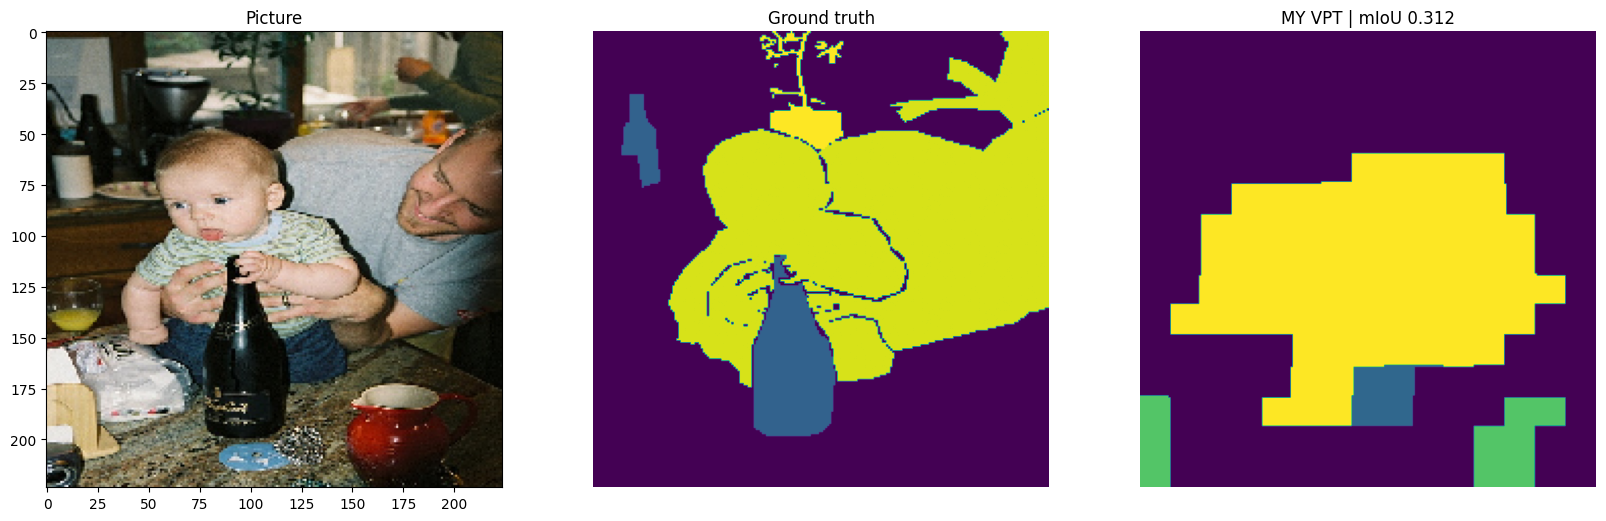

In [ ]:
image2, mask2 = test_set[19]
pred_mask2, score2 = predict_image_mask_miou(model2, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('MY VPT | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

In [ ]:
plt.imshow(image2)
plt.imshow(pred_mask2, alpha=0.5)
plt.title('Picture with Mask Appplied')
plt.show()

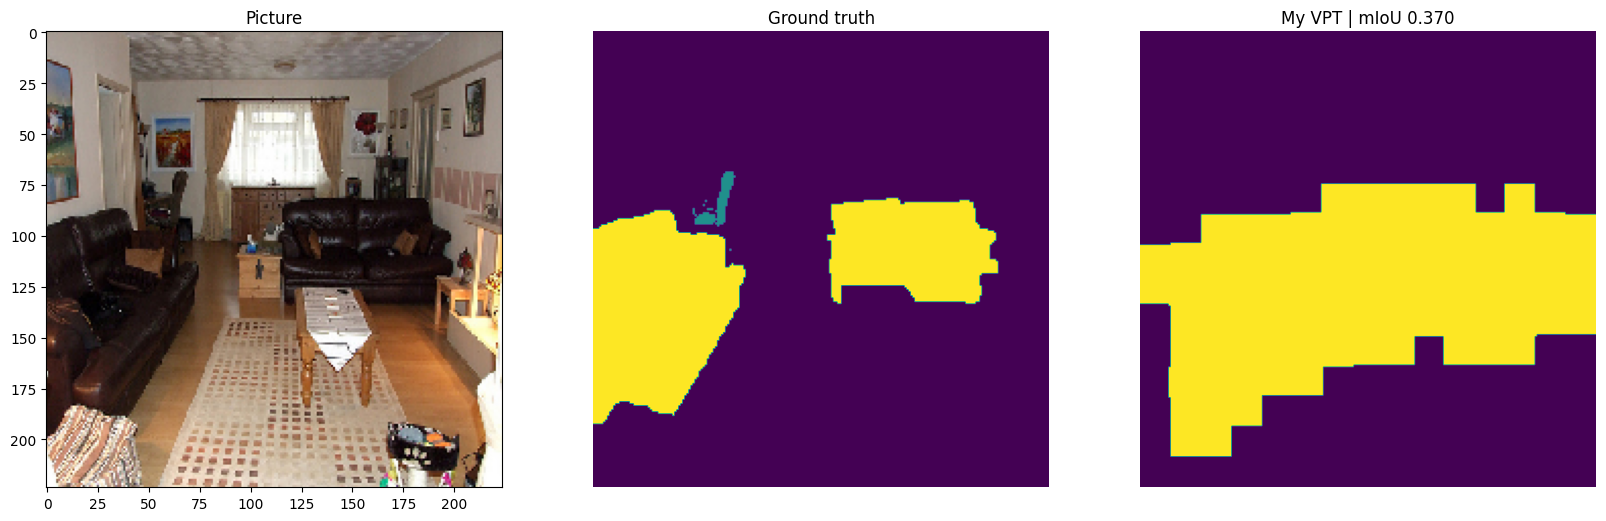

In [ ]:
image3, mask3 = test_set[14]
pred_mask3, score3 = predict_image_mask_miou(model2, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('My VPT | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()

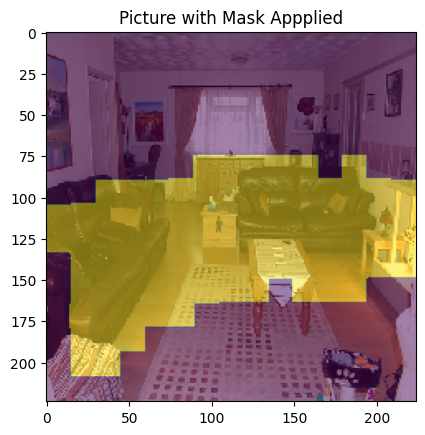

In [ ]:
plt.imshow(image3)
plt.imshow(pred_mask3, alpha=0.5)
plt.title('Picture with Mask Appplied')
plt.show()

In [ ]:
print('Test Set mIoU', np.nanmean(mob_miou))

prompt도 이용하여 segmentation 하면 어떨까

225x225로 만들면..?

In [ ]:
class SegmentationHead(nn.Module):
    def __init__(self, num_classes: int, hidden_dim: int = 768):
        super(SegmentationHead, self).__init__()
        # 업샘플링과 깊이별 분리 컨볼루션 레이어
        self.upsample = nn.Upsample(scale_factor=15, mode='bilinear')
        self.conv1 = DepthwiseSeparableConv(hidden_dim, hidden_dim // 15, kernel_size=3, padding=1)
        self.final_conv = nn.Conv2d(hidden_dim // 15, num_classes, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(hidden_dim // 15)
    def forward(self, x):

        # 첫 번째 컨볼루션 및 배치 정규화
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.upsample(x)
        # 최종 컨볼루션
        x = self.final_conv(x)
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        return x

In [ ]:
import math
import torch
import torch.nn as nn

class UsingPrompt(nn.Module):
    def __init__(self, modelname: str, num_classes: int, pretrained: bool = True,
                 prompt_tokens: int = 28, prompt_dropout: float = 0.5, prompt_type: str = 'shallow'):
        super().__init__()
        self.encoder = create_model(modelname, pretrained=pretrained)
        hidden_dim = self.encoder.embed_dim
        del self.encoder.head
        self.encoder.head = SegmentationHead(num_classes=num_classes, hidden_dim=hidden_dim)

        for n, p in self.encoder.named_parameters():
            if 'head' not in n:
                p.requires_grad = False

        self.prompt_tokens = prompt_tokens
        self.prompt_dropout = nn.Dropout(prompt_dropout)
        self.prompt_dim = self.encoder.embed_dim
        self.prompt_type = prompt_type
        assert self.prompt_type in ['shallow', 'deep'], "prompt type should be 'shallow' or 'deep'."

        self.prompt_embeddings = nn.Parameter(torch.zeros(1, self.prompt_tokens, self.prompt_dim))
        nn.init.uniform_(self.prompt_embeddings, -1, 1)

        if self.prompt_type == 'deep':
            self.total_d_layer = len(self.encoder.blocks)
            self.deep_prompt_embeddings = nn.Parameter(
                torch.zeros(self.total_d_layer-1, self.prompt_tokens, self.prompt_dim)
            )
            nn.init.uniform_(self.deep_prompt_embeddings, -1, 1)

    def train(self, mode=True):
        super().train(mode=False)
        self.prompt_dropout.train(mode)
        self.encoder.head.train(mode)

    def incorporate_prompt(self, x, prompt_embeddings, n_prompt: int = 0):
        B = x.shape[0]
        x = torch.cat((
            x[:, :1, :],
            self.prompt_dropout(prompt_embeddings.expand(B, -1, -1)),
            x[:, (1+n_prompt):, :]
        ), dim=1)
        return x

    def forward_features(self, x):
        x = self.encoder.patch_embed(x)
        cls_tokens = self.encoder.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.encoder.pos_embed
        x = self.encoder.pos_drop(x)

        x = self.incorporate_prompt(x, self.prompt_embeddings)

        if self.prompt_type == 'deep':
            for i, blk in enumerate(self.encoder.blocks):
                if i > 0:
                    x = self.incorporate_prompt(x, self.deep_prompt_embeddings[i-1], self.prompt_tokens)
                x = blk(x)
        else: #shallow
            x = self.encoder.blocks(x)

        x = self.encoder.norm(x)
        B, N, C = x.shape
        H = W = 15  # 업데이트된 그리드 크기
        x = x[:, :, :].permute(0, 2, 1).contiguous().view(B, C, H, W)

        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.encoder.head(x)
        return x


In [ ]:
model3 = UsingPrompt(modelname = 'vit_base_patch16_224',num_classes = 21,prompt_type='shallow')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
max_lr = 5e-2
epoch = 150
weight_decay = 0.0

criterion =  nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model3.parameters(), lr = max_lr, weight_decay=weight_decay)
# sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
#                                             steps_per_epoch=len(train_loader))
sched = CosineAnnealingWarmUpRestarts(optimizer,T_0=10, T_mult=1, eta_max = max_lr,  T_up=1, gamma=0.9)


history = fit(epoch, model3, train_loader, val_loader, criterion, optimizer, sched, '225x225_Using_ALL_dropout')

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.714 
Epoch:1/150.. Train Loss: 1.021.. Val Loss: 0.714.. Train mIoU:0.075.. Val mIoU: 0.136.. Train Acc:0.751.. Val Acc:0.760.. Time: 2.02m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Loss Decreasing.. 0.714 >> 0.634 
Epoch:2/150.. Train Loss: 0.810.. Val Loss: 0.634.. Train mIoU:0.127.. Val mIoU: 0.188.. Train Acc:0.762.. Val Acc:0.773.. Time: 2.01m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:3/150.. Train Loss: 0.753.. Val Loss: 0.646.. Train mIoU:0.154.. Val mIoU: 0.166.. Train Acc:0.767.. Val Acc:0.766.. Time: 1.97m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:4/150.. Train Loss: 0.731.. Val Loss: 0.813.. Train mIoU:0.165.. Val mIoU: 0.260.. Train Acc:0.771.. Val Acc:0.675.. Time: 1.98m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Loss Decreasing.. 0.813 >> 0.590 
Epoch:5/150.. Train Loss: 0.744.. Val Loss: 0.590.. Train mIoU:0.164.. Val mIoU: 0.171.. Train Acc:0.766.. Val Acc:0.780.. Time: 1.98m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:6/150.. Train Loss: 0.702.. Val Loss: 0.601.. Train mIoU:0.165.. Val mIoU: 0.283.. Train Acc:0.775.. Val Acc:0.764.. Time: 2.00m


  0%|          | 0/70 [00:00<?, ?it/s]